# DI 725: Transformers and Attention-Based Deep Networks

## An Assignment for Implementing Transformers in PyTorch

The purpose of this notebook is to guide you through the usage of sample code.

This notebook follows the baseline prepared by Andrej Karpathy, with a custom dataset (Don-Quixote by Cervantes). This version of the code, called [nanoGPT](https://github.com/karpathy/nanoGPT), is a revisit to his famous [minGPT](https://github.com/karpathy/minGPT).
### Author:
* Ümit Mert Çağlar

## Requirements
Install requirements for your environment, comment out for later uses.

Dependencies:

- [pytorch](https://pytorch.org)
- [numpy](https://numpy.org/install/)
-  `transformers` for huggingface transformers (to load GPT-2 checkpoints)
-  `datasets` for huggingface datasets (to download + preprocess datasets)
-  `tiktoken` for OpenAI's fast BPE code
-  `wandb` for optional logging
-  `tqdm` for progress bars

In [ ]:
from google.colab import drive
#mounting google drive for google colab
drive.mount('/content/drive')

#changing directory for relative paths to work
%cd /content/drive/MyDrive/DI725/DI725-assignment1/DI725-assignment1/

In [ ]:
!pip install torch numpy transformers datasets tiktoken wandb tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

The fastest way to get started to transformers, apart from following the labs of DI725, is to use a small model and dataset. For this purpose, we will start with training a character-level GPT on the Don-Quixote by Cervantes. The code will download a single file (2MB) and apply some transformations. Examine the code [prepare.py](data/don_char/prepare.py).

#Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

#Loading the training and testing datasets
train_dataset = pd.read_csv("data/customer_service/train.csv")
test_dataset = pd.read_csv("data/customer_service/test.csv")

print(f"Available features: {train_dataset.columns.values}")
print(f"Number of columns(features): {len(train_dataset.columns)}")
print(f"Number of training examples: {len(train_dataset)}")

train_dataset.head()

Available features: ['issue_area' 'issue_category' 'issue_sub_category'
 'issue_category_sub_category' 'customer_sentiment' 'product_category'
 'product_sub_category' 'issue_complexity' 'agent_experience_level'
 'agent_experience_level_desc' 'conversation']
Number of columns(features): 11
Number of training examples: 970


,issue_area,issue_category,issue_sub_category,issue_category_sub_category,customer_sentiment,product_category,product_sub_category,issue_complexity,agent_experience_level,agent_experience_level_desc,conversation
0,Login and Account,Mobile Number and Email Verification,Verification requirement for mobile number or ...,Mobile Number and Email Verification -> Verifi...,neutral,Appliances,Oven Toaster Grills (OTG),medium,junior,"handles customer inquiries independently, poss...",Agent: Thank you for calling BrownBox Customer...
1,Cancellations and returns,Pickup and Shipping,Reasons for being asked to ship the item,Pickup and Shipping -> Reasons for being asked...,neutral,Electronics,Computer Monitor,less,junior,"handles customer inquiries independently, poss...",Agent: Thank you for calling BrownBox customer...
2,Cancellations and returns,Replacement and Return Process,Inability to click the 'Cancel' button,Replacement and Return Process -> Inability to...,neutral,Appliances,Juicer/Mixer/Grinder,medium,experienced,"confidently handles complex customer issues, e...",Agent: Thank you for calling BrownBox Customer...
3,Login and Account,Login Issues and Error Messages,Error message regarding exceeded attempts to e...,Login Issues and Error Messages -> Error messa...,neutral,Appliances,Water Purifier,less,inexperienced,"may struggle with ambiguous queries, rely on c...","Customer: Hi, I am facing an issue while loggi..."
4,Order,Order Delivery Issues,Delivery not attempted again,Order Delivery Issues -> Delivery not attempte...,negative,Electronics,Bp Monitor,medium,experienced,"confidently handles complex customer issues, e...",Agent: Thank you for contacting BrownBox custo...


What we are conserned with is the customer sentiment. Now let's see how customer sentiment is distributed and what other features correlate with customer sentiment:

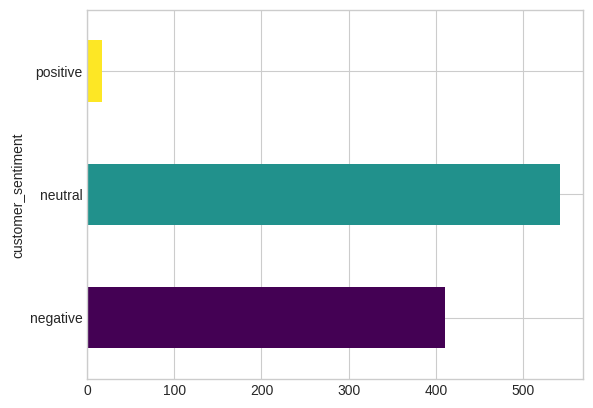

In [ ]:
#Distribution of customer sentiment
train_dataset.groupby('customer_sentiment').size().plot(kind='barh', color=["#440154","#21918c", "#fde725"]).plot()
plt.show()

Here we see that majority of the customer sentiments are neutral, with negatives closely following in number while only a small minority are positive. This might cause problems later training, as we have a low number positive examples.

How about correlation with other features?

issue_area


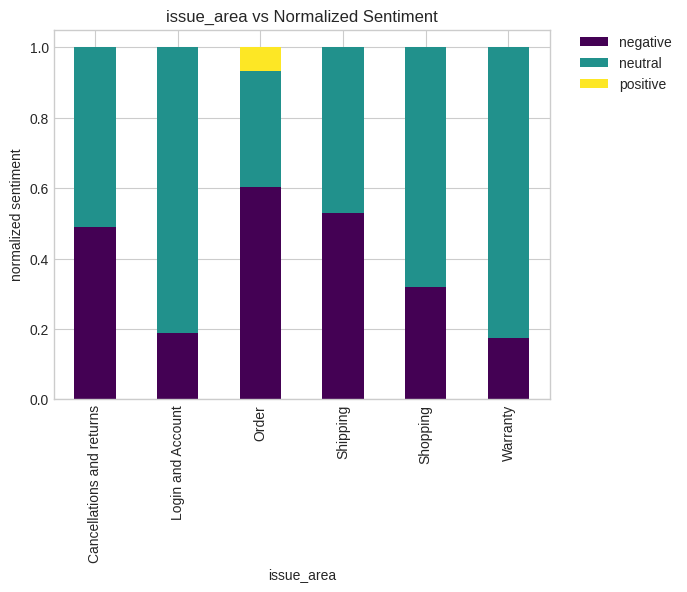

issue_category


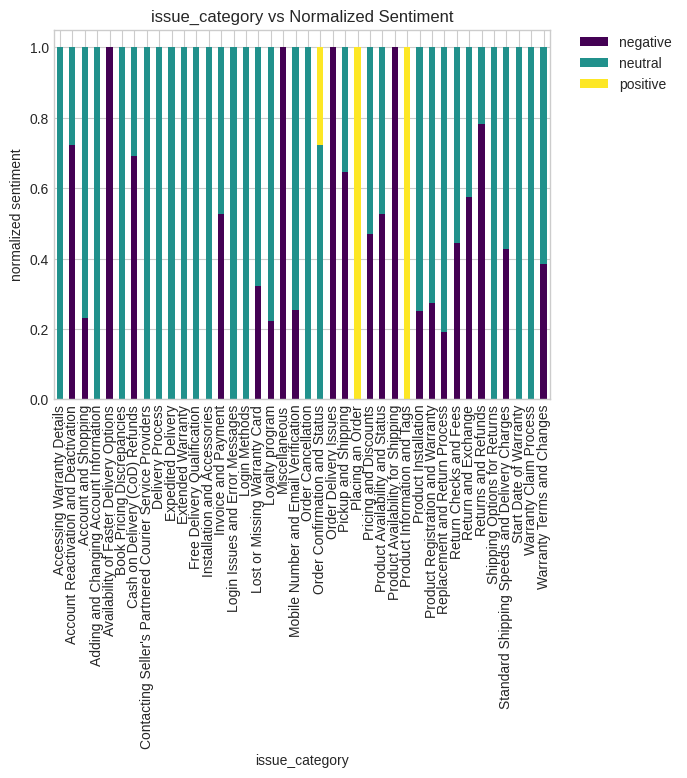

product_category


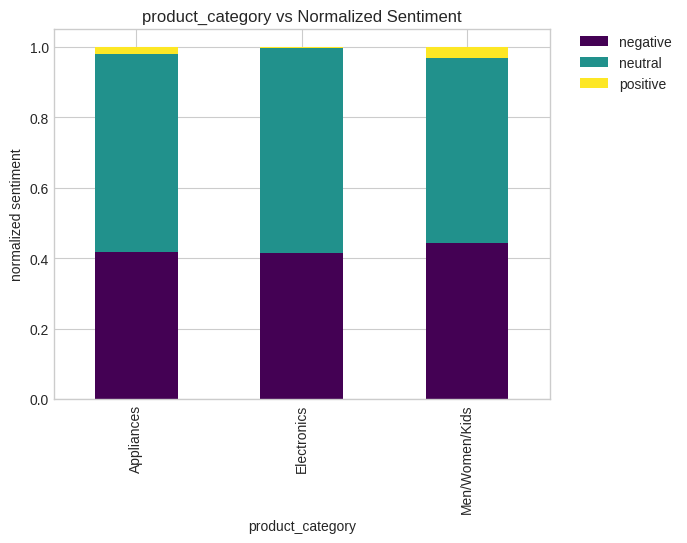

agent_experience_level


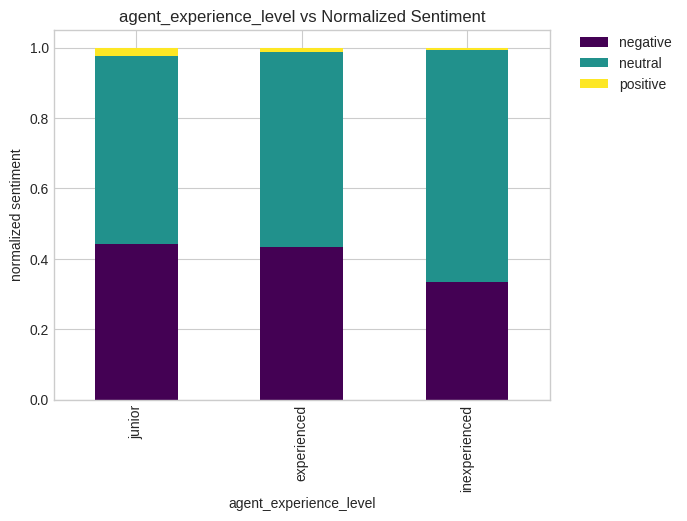

issue_complexity


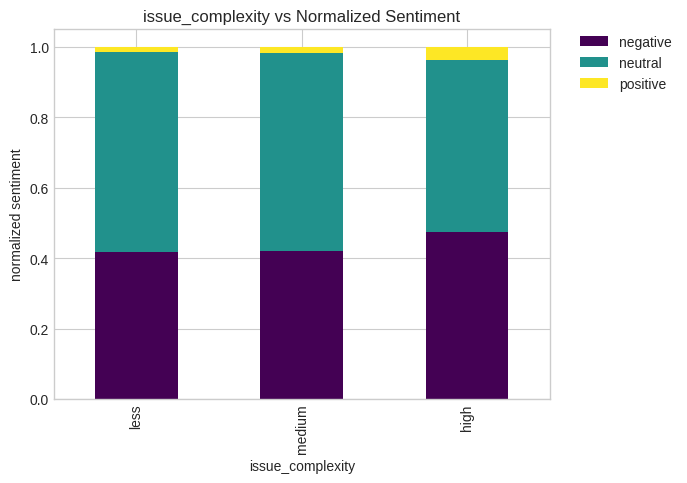

In [ ]:
select_features = ['issue_area', 'issue_category','product_category',
                   'agent_experience_level','issue_complexity']

for feature in select_features:
  print(feature)

  df = pd.DataFrame({
      x_label: grp[feature].value_counts()
      for x_label, grp in train_dataset.groupby('customer_sentiment')
  })


  #normalize based on total number of observation in each row
  df_normalized = df.div(df.sum(axis=1), axis=0)

  #plot
  ax = df_normalized.plot(kind='bar', stacked=True, cmap="viridis")
  ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  ax.set_ylabel('normalized sentiment')
  ax.set_title(f'{feature} vs Normalized Sentiment')

  plt.show()

We see that all of the positive reviews are under the issue area "Order", furthermore issue_category is a good predictor of customer sentiment. We see that customer sentiments that fall onther  "Product information and Tags" and "Placing an Order" categories are all positive; whereas certain categories such as "Availability of Faster Delivery Options" are all negative. We don't see any apparent or significant looking correlations in other features that we have examined.

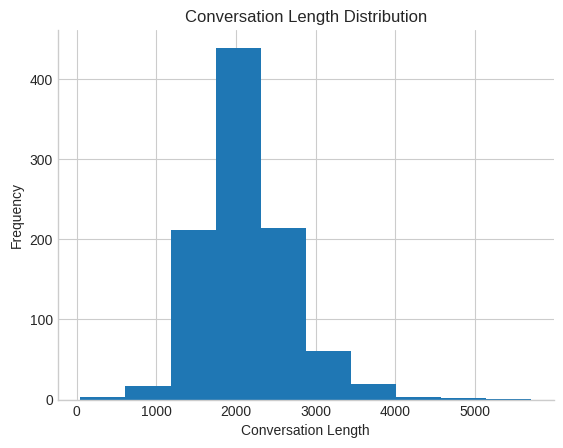

In [ ]:
train_dataset["conversation_length"]=train_dataset["conversation"].str.len()

ax = train_dataset["conversation_length"].plot(kind = "hist")
ax.set_title("Conversation Length Distribution")
ax.set_xlabel("Conversation Length")
ax.set_ylabel("Frequency")
ax.spines[['right', 'top']].set_visible(False)

plt.show()

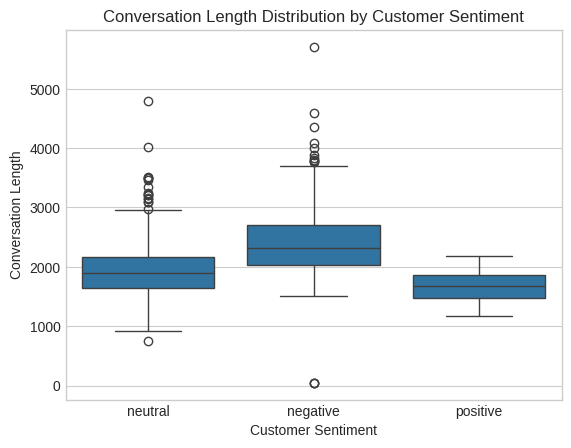

In [ ]:
ax = sns.boxplot(data=train_dataset, x='customer_sentiment', y='conversation_length')
ax.set_title("Conversation Length Distribution by Customer Sentiment")
ax.set_xlabel("Customer Sentiment")
ax.set_ylabel("Conversation Length")

plt.show()

Here we also see that longer conservations tend to be more negative than both shorter conversations and neutral ones.

## Preprocessing

Use the following to prepare the customer sentiment treated in character level:

In [ ]:
!python data/customer_service/prepare_char.py

Dataset shape: (970, 11)
Number of conversations: 970

Total text length: 2,066,375 characters
Text vocabulary size: 87 unique characters
Character set: ['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '’']

Number of unique sentiment labels: 3
Labels: ['negative', 'neutral', 'positive']

Label to index mapping:
  negative -> 0
  neutral -> 1
  positive -> 2

Training set size: 776
Validation set size: 194

Data preparation complete!


This creates a `train_char.bin` and `val_char.bin` in that data directory. Now it is time to train our own GPT. The size of the GPT model depends on the computational resources. It is advised to have a GPU for heavy works, and to train lightweight and evaluate and infer models with a CPU.

Small scale GPT with the settings provided in the [config/train_don_char.py](config/train_don_char.py) config file will be trained with the following code:


## Training nanoGPT

In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yildizz-nisan (yildizz-nisan-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
!python train.py config/train_sent_char.py --compile=False

Overriding config with config/train_sent_char.py:
# train a miniature character-level shakespeare model
# good for debugging and playing on macbooks and such

out_dir = 'out-sent-char'
eval_interval = 250  # keep frequent because we'll overfit
eval_iters = 200
log_interval = 50  # don't print too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = True  # override via command line if you like
wandb_project = 'customer_sentiment'
wandb_run_name = 'nano-gpt'

dataset = 'customer_sentiment'
gradient_accumulation_steps = 1
batch_size = 64
block_size = 1024  # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2

learning_rate = 1e-3  # with baby networks can afford to go a bit higher
max_iters = 2000
lr_decay_iters = 2000  # make equal to max_iters usually
min_lr = 1e-4  # learning_rate / 10 usually
beta2 = 0.99  # make a bit bigger because number of tokens

In [ ]:
import torch
from torch.nn import functional as F
from model import GPTConfig, GPT
import pickle

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

block_size = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

ckpt_path = "out-sent-char/ckpt.pt"
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)

model.eval()
model.to(device)

meta_path = "data/customer_service/sentiment_meta.pkl"

print(f"Loading meta from {meta_path}...")
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

stoi, itos, label_itos = meta['text_stoi'], meta['text_itos'], meta['label_itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

decode_label = lambda s: label_itos[s]

test_df = pd.read_csv("data/customer_service/test.csv")

def process_input_text(str, block_size):

  encoded_text = encode(str)

  if len(encoded_text) <= block_size:
      # Pad shorter sequences with zeros
      encoded_text = encoded_text + [0] * (block_size - len(encoded_text))

  else:
      # For longer sequences, take a random slice of length block_size
      start_idx = torch.randint(0, len(encoded_text) - block_size + 1, (1,)).item()
      encoded_text = encoded_text[start_idx:start_idx+block_size]

  input_tensor = torch.tensor([encoded_text], dtype=torch.long)
  input_tensor = input_tensor.to(device)

  return input_tensor

def get_predictions(input_tensor):
  with torch.no_grad():
    result = model.forward(input_tensor)
  probs = F.softmax(result[0], dim = -1)
  print(probs)
  predictions = torch.argmax(probs, dim=-1)
  decoded_predictions = [decode_label(pred.item()) for pred in predictions]

  return decoded_predictions

predicted_sentiments = []
for i in range(len(test_df)):
  input_text = test_df["conversation"][i]
  input_tensor = process_input_text(input_text, block_size)
  predictions = get_predictions(input_tensor)

  predicted_sentiments.append(predictions[0])




cuda
number of parameters: 10.66M
Loading meta from data/customer_service/sentiment_meta.pkl...
tensor([[0.3956, 0.5832, 0.0212]], device='cuda:0')
tensor([[0.4266, 0.5540, 0.0194]], device='cuda:0')
tensor([[0.3711, 0.6063, 0.0225]], device='cuda:0')
tensor([[0.3707, 0.6055, 0.0238]], device='cuda:0')
tensor([[0.4991, 0.4852, 0.0157]], device='cuda:0')
tensor([[0.3609, 0.6152, 0.0239]], device='cuda:0')
tensor([[0.3755, 0.6022, 0.0223]], device='cuda:0')
tensor([[0.4001, 0.5781, 0.0217]], device='cuda:0')
tensor([[0.4336, 0.5476, 0.0188]], device='cuda:0')
tensor([[0.5294, 0.4566, 0.0140]], device='cuda:0')
tensor([[0.3578, 0.6178, 0.0244]], device='cuda:0')
tensor([[0.5275, 0.4585, 0.0140]], device='cuda:0')
tensor([[0.3955, 0.5838, 0.0207]], device='cuda:0')
tensor([[0.3418, 0.6325, 0.0257]], device='cuda:0')
tensor([[0.4178, 0.5621, 0.0201]], device='cuda:0')
tensor([[0.3723, 0.6044, 0.0233]], device='cuda:0')
tensor([[0.4240, 0.5565, 0.0195]], device='cuda:0')
tensor([[0.5178, 0.4

In [ ]:
(predicted_sentiments == test_df["customer_sentiment"]).sum() / len(test_df)



np.float64(0.3333333333333333)

We are training a small scaled GPT with a context size of up to 256 characters, 384 feature channels, 6 layers of transformer with 6 attention heads. On one GTX 3070 GPU this training run takes about 10 minutes and the best validation loss is 1.1620. Based on the configuration, the model checkpoints are being written into the `--out_dir` directory `out-don-char`. So once the training finishes we can sample from the best model by pointing the sampling script at this directory:

*Here, since we are running on CPU instead of GPU we must set both `--device=cpu` and also turn off PyTorch 2.0 compile with `--compile=False`. Then when we evaluate we get a bit more noisy but faster estimate (`--eval_iters=20`, down from 200), our context size is only 64 characters instead of 256, and the batch size only 12 examples per iteration, not 64. We'll also use a much smaller Transformer (4 layers, 4 heads, 128 embedding size), and decrease the number of iterations to 2000 (and correspondingly usually decay the learning rate to around max_iters with `--lr_decay_iters`). Because our network is so small we also ease down on regularization (`--dropout=0.0`). This still runs in about ~5 minutes, but gets us a loss of only 1.88 and therefore also worse samples, but it's still good fun:*

*Not bad for ~3 minutes on a CPU, for a hint of the right character gestalt. If you're willing to wait longer, feel free to tune the hyperparameters, increase the size of the network, the context length (`--block_size`), the length of training, etc.*

*Finally, on Apple Silicon Macbooks and with a recent PyTorch version make sure to add `--device=mps` (short for "Metal Performance Shaders"); PyTorch then uses the on-chip GPU that can *significantly* accelerate training (2-3X) and allow you to use larger networks. See [Issue 28](https://github.com/karpathy/nanoGPT/issues/28) for more.*



## Finetuning

Finetuning or transfer learning is a precious method of achieving better models thanks to pre-trained models. Finetuning GPT models is just as simple as training from scratch! We will now download the Don-Quixote (again) but this time we will define it with tokens (using OpenAI's BPE tokenizer) instead of characters.



In [ ]:
!python data/don/prepare.py

train has 592,353 tokens
val has 66,303 tokens


Run an example finetuning like:

In [ ]:
!python train.py config/finetune_don.py --compile=False

Overriding config with config/finetune_don.py:
import time

out_dir = 'out-don'
eval_interval = 5
eval_iters = 40
wandb_log = False # feel free to turn on
wandb_project = 'don'
wandb_run_name = 'ft-' + str(time.time())

dataset = 'don'
init_from = 'gpt2' # this is the GPT-2 model

# only save checkpoints if the validation loss improves
always_save_checkpoint = False

# the number of examples per iter:
batch_size = 1
gradient_accumulation_steps = 32
max_iters = 20

# finetune at constant LR
learning_rate = 3e-5
decay_lr = False

Overriding: compile = False
tokens per iteration will be: 32,768
Initializing from OpenAI GPT-2 weights: gpt2
loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M
num decayed parameter tensors: 50, with 124,318,464 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
step 0: train loss 3.3541, val loss 3.3616
iter 0:

This will load the config parameter overrides in `config/finetune_don.py`. Basically, we initialize from a GPT2 checkpoint with `init_from` and train as normal, except shorter and with a small learning rate. Model architecture is changable to `{'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}`) and can be decreased in size by the `block_size` (context length). The best checkpoint (lowest validation loss) will be in the `out_dir` directory, e.g. in `out-don` by default, per the config file. You can then run the code in `sample.py --out_dir=out-don`:
```
* * All creatures that enter the world below may so far as want to observe the rules of their own land, and may obey them under the hand of their lord, and may not follow others below.

* * *

THE PORT COLLIDATES,

- * *

ON the light, and the light to the dark, and the darkness to the light, and the darkness to the darkness, were the present-day laws of monarchy, whose lordship they approved in their faces and hearts. From this moment on, however, they had no other representation to give than that of their master, who, for all that was said or heard, had reached the height of his power.

The king's hand, though at times little more than a finger of his, required no more than a finger of his, and that power was, that of holding his eye, and the other of his, in his own, body.

When this was spoken of, it was a simple and noble quibble, and the subject of this was so as to admit of the few who had any forsemination, and the few who had the most to go on.

The time did not come for a thought of this, and for a moment the very thought of it seemed to fall to the ground.

But that thought did not come to pass; though the king was not speaking of the king, it came to pass that the king, with all his might, and all his cunning, and no other sense, and without any understanding, and without any desire for the utmost of his services, and without any desire to put an end to his own glory, and without any desire to hide his triumph, had found the time to say that this was what he thought on the subject of religion; that it was what he thought, and according as it seemed to him to be as good or better to him than to the other kings, and he was in no sense a king, for it seemed to him he could never have any more power than he had to be; that it was a matter of his will and power; and that it was all a matter of his will, for he was determined that this look and that to which he might have been given to hold it was the best in himself.

And so it was that the king, who was all around him, and all around him; and so
```

# Inference and Sampling
Use the script `sample.py` to sample either from pre-trained GPT-2 models released by OpenAI, or from a model you trained yourself. For example, here is a way to sample from the largest available `gpt2-xl` model:

In [ ]:
!python sample.py --out_dir=out-don --start="Explain the relationship between Don Quixote and Sancho Panza" --num_samples=5 --max_new_tokens=100

Overriding: out_dir = out-don
Overriding: start = Explain the relationship between Don Quixote and Sancho Panza
Overriding: num_samples = 5
Overriding: max_new_tokens = 100
number of parameters: 123.65M
No meta.pkl found, assuming GPT-2 encodings...
Explain the relationship between Don Quixote and Sancho Panza. The story, according to the newspapers, is that the two men want to take over the city, and that Sancho has accepted that.

I have been told that Don Quixote was not the first man to arrive to the city, and that Sancho was not the first. I have no reason to doubt that, for Don Quixote is an itinerant man, who is always crossing the country, and with a lot of money. I have been told that many other
---------------
Explain the relationship between Don Quixote and Sancho Panza, the magician who is almost always mistaken for the Countess of Sancho Panza. This is a trick used by the Countess of Sancho Panza.

The Countess of Sancho Panza is made the subject of many rumors, but the tr

If you'd like to sample from a model you trained, use the `--out_dir` to point the code appropriately. You can also prompt the model with some text from a file, e.g.:

In [ ]:
!python sample.py --start=FILE:"prompt/fictional.txt" --out_dir="out-don" --num_samples=1 --max_new_tokens=100

Overriding: start = FILE:prompt/fictional.txt
Overriding: out_dir = out-don
Overriding: num_samples = 1
Overriding: max_new_tokens = 100
number of parameters: 123.65M
No meta.pkl found, assuming GPT-2 encodings...
Dain charges head on with his warhammer and full plate clad armor. Determined to topple anything in front of him.

One of the last bastions of the Dawn so far held in the voids held a massive wattle and rotted horse that had been drenched in sweat and had been stripped of its armour. Its bones were cast into the ground and then buried in the snow.

The dragon charged and made a wry noise, and turned back to face the Dawn. He glanced at the dragon, and then at Dain with a smile that was almost full of fear, but that made
---------------


In [ ]:
!python sample.py --start=FILE:"prompt/positive_review.txt" --out_dir="out-don" --num_samples=1 --max_new_tokens=500

Overriding: start = FILE:prompt/positive_review.txt
Overriding: out_dir = out-don
Overriding: num_samples = 1
Overriding: max_new_tokens = 500
number of parameters: 123.65M
No meta.pkl found, assuming GPT-2 encodings...
This place was DELICIOUS!! My parents saw a recommendation to visit this place from Rick Sebak's \"25 Things I Like About Pittsburgh\" and he's usually pretty accurate. His recommendations were to try the Reuben, Fish Sandwich and Open-Faced Steak Sandwich. We went early afternoon for a late lunch today (a Saturday) and were seated right away. The staff is extremely friendly. My Mom & I each had the fish sandwich, while my Dad & Brother had a Reuben sandwich. The fish was very good, but the Reuben was to die for! Both dishes were massive, and could very easily be shared between two people. On top of being extremely large portions, it was incredibly affordable. The giant fish sandwich was $8 and the giant Reuben was $7.50. Our drinks were always filled and we were checke

I hope you will enjoy with the GPT as much as I did!

## Efficiency notes

*For simple model benchmarking and profiling, `bench.py` might be useful. It's identical to what happens in the meat of the training loop of `train.py`, but omits much of the other complexities.*

*Note that the code by default uses [PyTorch 2.0](https://pytorch.org/get-started/pytorch-2.0/). At the time of writing (Dec 29, 2022) this makes `torch.compile()` available in the nightly release. The improvement from the one line of code is noticeable, e.g. cutting down iteration time from ~250ms / iter to 135ms / iter. Nice work PyTorch team!*


## Troubleshooting

*Note that by default this repo uses PyTorch 2.0 (i.e. `torch.compile`). This is fairly new and experimental, and not yet available on all platforms (e.g. Windows). If you're running into related error messages try to disable this by adding `--compile=False` flag. This will slow down the code but at least it will run.*

*For some context on this repository, GPT, and language modeling it might be helpful to watch [Zero To Hero series](https://karpathy.ai/zero-to-hero.html). Specifically, the [GPT video](https://www.youtube.com/watch?v=kCc8FmEb1nY) is popular if you have some prior language modeling context.*

## Acknowledgements

This code is a fork from Andrej Karpathy's introductory [NanoGPT repository](https://github.com/karpathy/nanoGPT), which is an updated form of minGPT.

# Further Experiments

(Optional)

For further experiments, you can, for example, reproduce the GPT-2, which is still powerful, by following the link to the Andrej Karpathy's repository.